In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)


# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT','IS','PS','L','T','RR','V','ρ','Λ','GR']

#determine the ionic charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
data['IS_charge'] = data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)


# determine the columns that are used as features in classification
features = ['M', 'L', 'V', 'T', 'GR']

X = data[features].copy()
y = data['ρ']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

[0.44257325755172217, 0.4798305672498222, 0.5257834273690869, 0.6206547889048031, 0.518316335077015, 0.6138550527438975, 0.6314437219830213, 0.6406691057757172, 0.5823447423000145, 0.6621253235805047, 0.6595160253330603, 0.6631166115190461]
[0.4697007999464988, 0.5798352639855215, 0.5931374519954385, 0.6294310109826591, 0.6358886994322821, 0.6350005273183862, 0.6842903277638147, 0.670893102083975, 0.6557599417108454, 0.6641076527836862, 0.6013179178041348, 0.6203857360858938]
[0.42773714012699, 0.3991480289747392, 0.3638864538272324, 0.2910876414039008, 0.36961626988888546, 0.2963053668512114, 0.282808836265077, 0.2757298086914623, 0.32048456215602, 0.2592655443444514, 0.26126776936364987, 0.25850488713950326]
[0.4221710314165016, 0.3344930181870512, 0.32390315036964495, 0.29500985912978506, 0.28986889532469395, 0.29057596887366594, 0.2513363737728988, 0.26200190105034316, 0.27404940540763983, 0.2674037951686792, 0.31739068403445847, 0.3022107997162086]


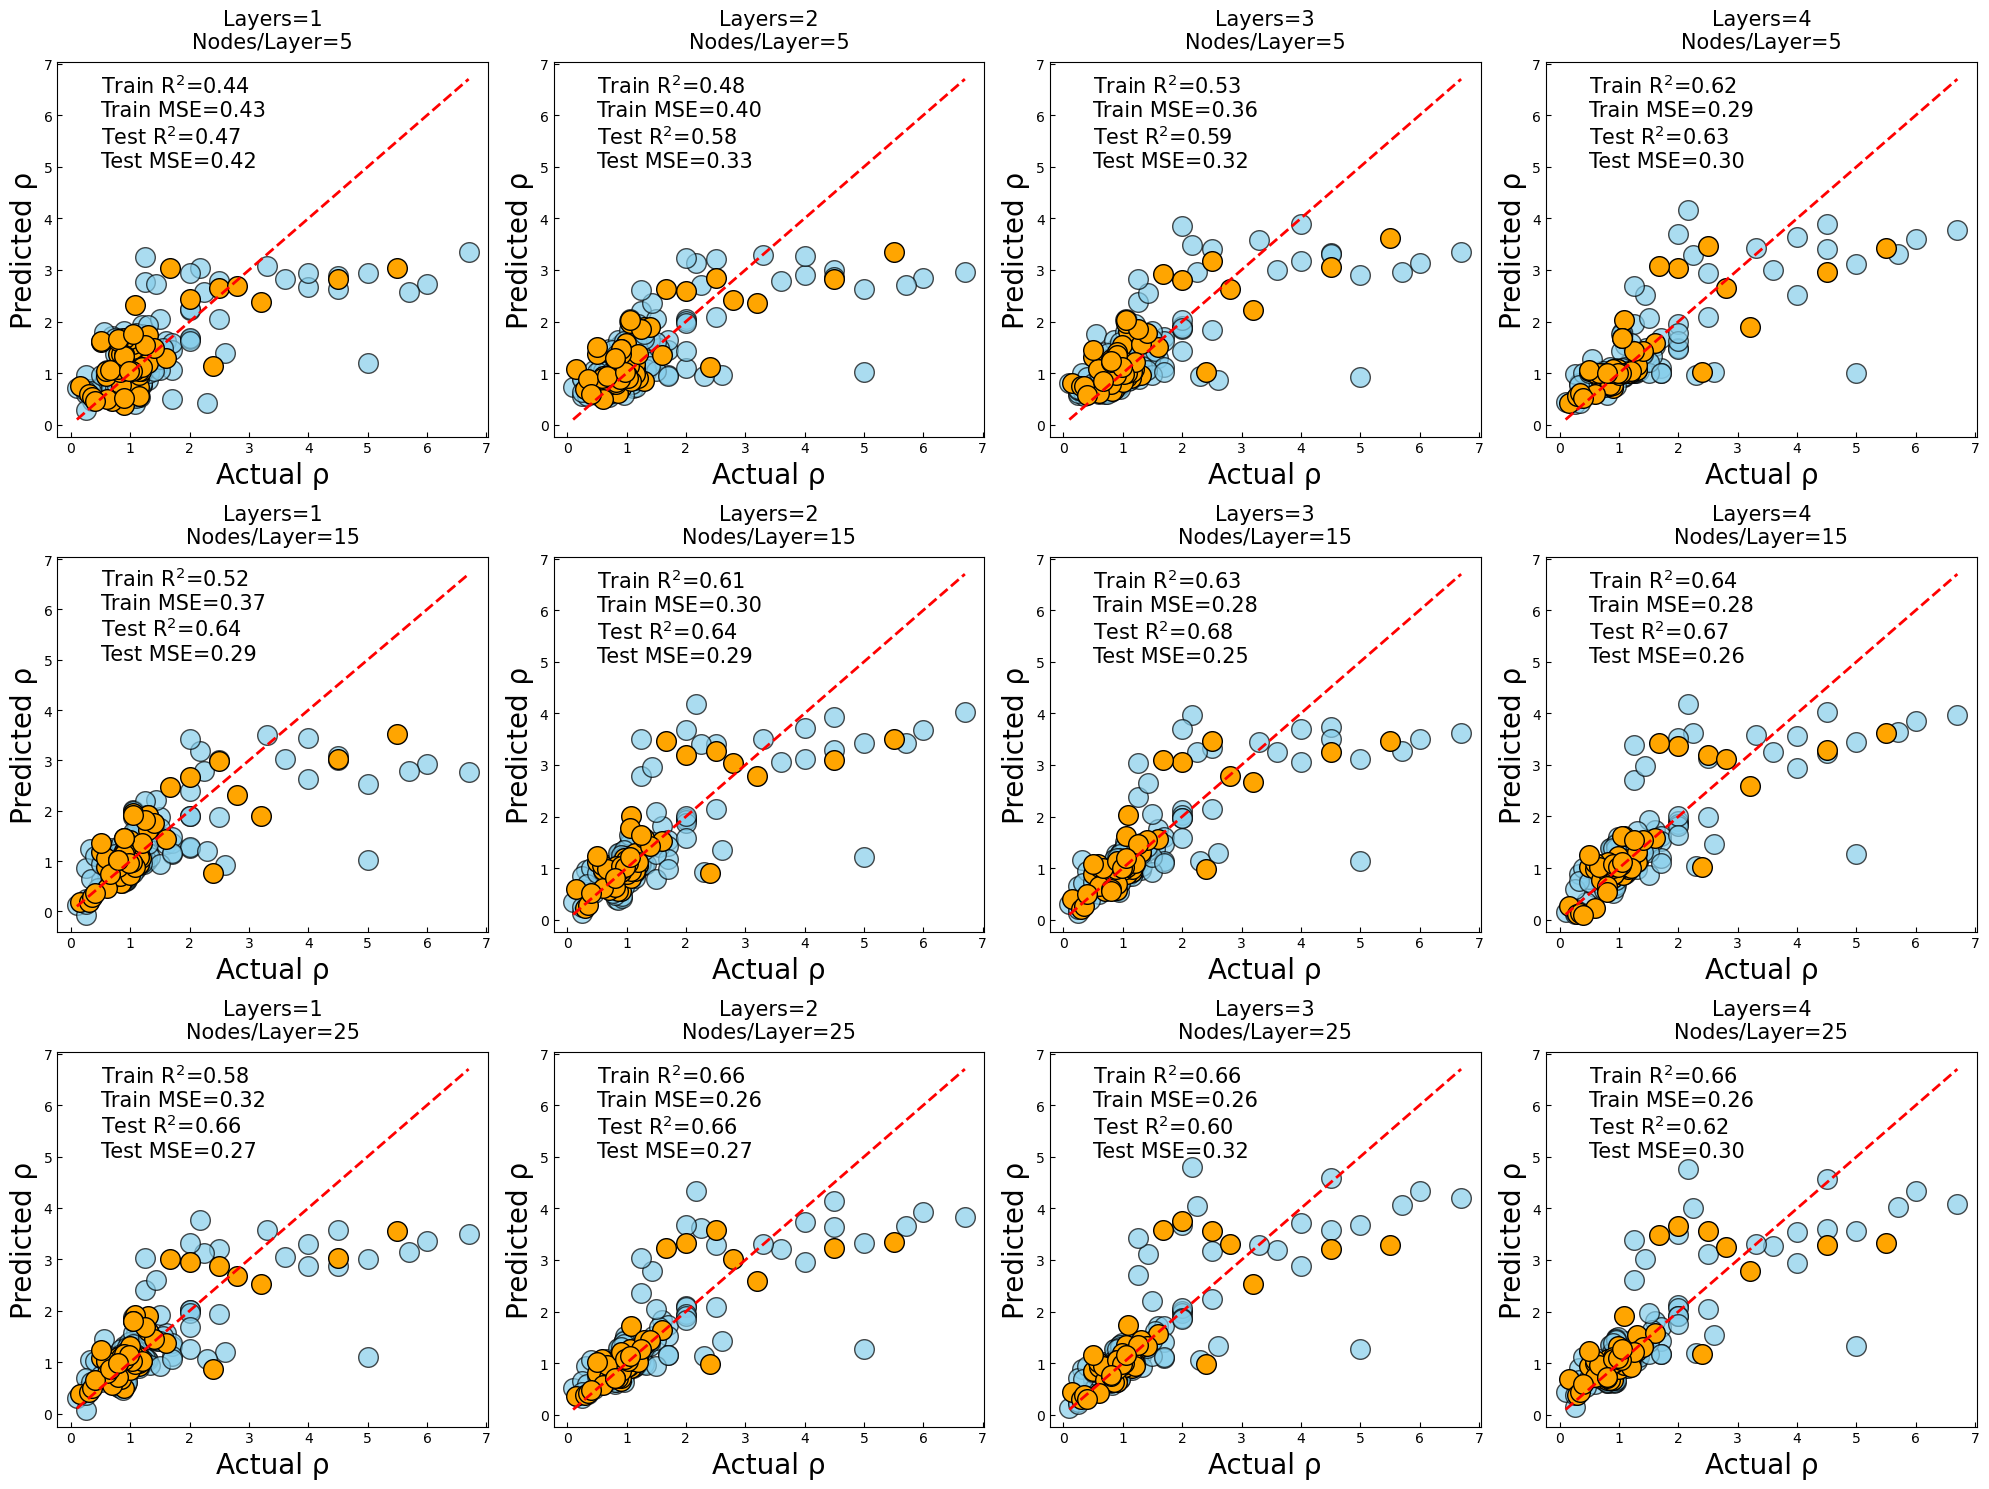

In [4]:
from sklearn.neural_network import MLPRegressor

m_nodes = [5, 15, 25]
n_layers = [1, 2, 3, 4]

fig, subaxes = plt.subplots(len(m_nodes), len(n_layers), figsize=(len(n_layers)*5, len(m_nodes)*5))

all_train_r2 = []
all_test_r2 = []
test_mse_all=[]
train_mse_all=[]

for i, m in enumerate(m_nodes):
    for j, n in enumerate(n_layers):
        layer_sizes = (m,) * n
        nn = MLPRegressor(hidden_layer_sizes=layer_sizes, max_iter=1000, activation='relu', solver='adam', random_state=0)
        nn.fit(X_train, y_train)
        y_pred_test = nn.predict(X_test)
        y_pred_train = nn.predict(X_train)

        subaxes[i, j].scatter(y_train, y_pred_train, s=200, alpha=0.7, edgecolors='black', c='skyblue')
        subaxes[i, j].scatter(y_test, y_pred_test, s=200, edgecolors='black', c='orange')
        subaxes[i, j].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        subaxes[i, j].set_title(f'Layers={n}\nNodes/Layer={m}', pad=10, fontsize=15)
        subaxes[i, j].set_xlabel('Actual ρ', size=20)
        subaxes[i, j].set_ylabel('Predicted ρ', size=20)

        train_score = nn.score(X_train, y_train)
        test_score = nn.score(X_test, y_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        mse_train = mean_squared_error(y_train, y_pred_train)
        all_train_r2.append(train_score)
        all_test_r2.append(test_score)
        test_mse_all.append(mse_test)
        train_mse_all.append(mse_train)
        
        subaxes[i, j].text(0.5, 5, f'Train R$^{2}$={train_score:.2f}\nTrain MSE={mse_train:.2f}\nTest R$^{2}$={test_score:.2f}\nTest MSE={mse_test:.2f}', fontsize=15)
        subaxes[i, j].tick_params(which='both', direction='in', labelsize=10)

print(all_train_r2)
print(all_test_r2)
print(train_mse_all)
print(test_mse_all)

plt.tight_layout()
plt.savefig('NN prediction matrix.jpg', format='jpeg', dpi=600)
plt.show()

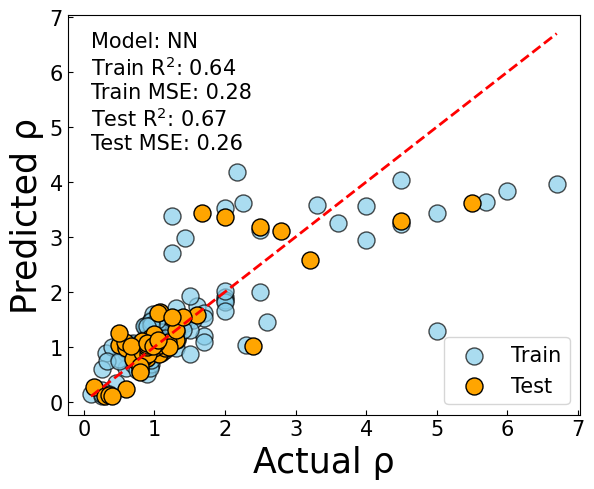

In [5]:
from sklearn.neural_network import MLPRegressor

nn_best = MLPRegressor(hidden_layer_sizes=(15,) * 4, max_iter=1000, activation='relu', solver='adam', random_state=0)
nn_best.fit(X_train, y_train)

y_predict_test = nn_best.predict(X_test)
y_predict_train = nn_best.predict(X_train)

train_score = nn_best.score(X_train, y_train)
test_score = nn_best.score(X_test, y_test)
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)

fig1 = plt.figure(figsize=(6,5))
plt.scatter(y_train, y_predict_train, s=150, c='skyblue', alpha=0.7, label='Train', edgecolors='black')
plt.scatter(y_test, y_predict_test, s=150, c='orange', label='Test', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(0.1, 4.6, f'Model: NN\nTrain R$^{2}$: {train_score:.2f}\nTrain MSE: {train_mse:.2f}\nTest R$^{2}$: {test_score:.2f}\nTest MSE: {test_mse:.2f}', fontsize=15)
plt.legend(loc=4, fontsize=15, frameon=True)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.tight_layout()
plt.savefig('NN Actual vs. Predicted.jpg', format='jpeg', dpi=600)
plt.show()

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

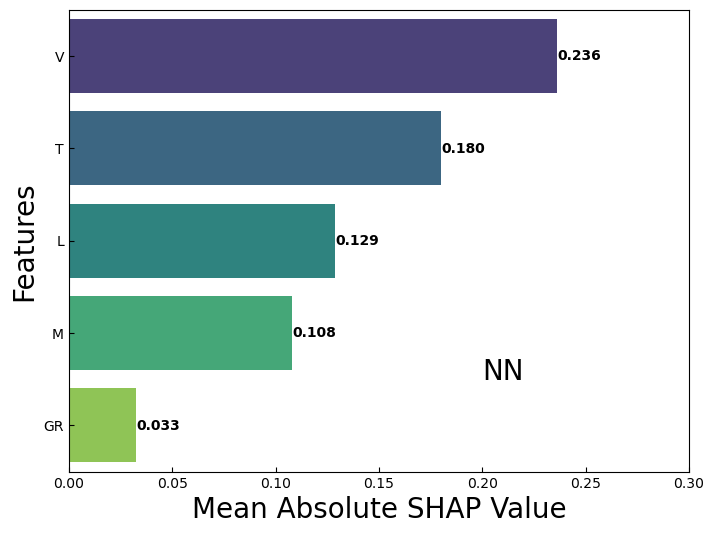

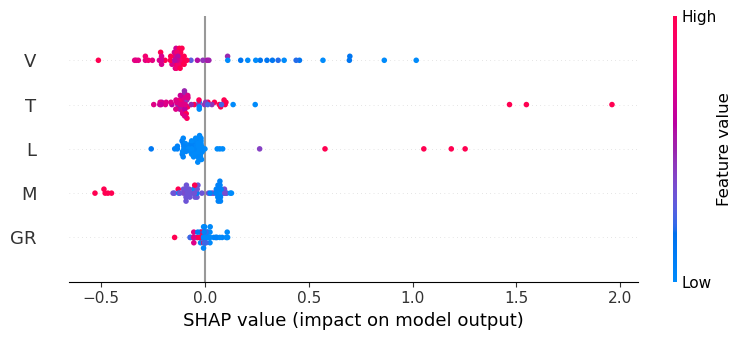

In [6]:
# use SHAP to explain and visualize the feature importance
import seaborn as sns
import shap
shap.initjs()
# Creating the KernelExplainer
nn_explainer = shap.KernelExplainer(nn_best.predict, X_train)
nn_shap_values = nn_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(nn_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0,0.3)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.text(0.2, len(importance_df) - 1.5, 'NN', fontsize=20)
plt.savefig('NN SHAP.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(nn_shap_values, X_test, feature_names=X.columns)